## First AI Agent

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph==0.3.21

In [3]:
from langchain_openai import ChatOpenAI
import openai

### Model

In [4]:
llm_model = ChatOpenAI(temperature=0.0, 
                        model="gpt-4-turbo",
                       openai_api_key="XXXXX")

In [5]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

### Tools

In [7]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def add(a: int, b: int) -> int:
    """add two numbers."""
    return a + b

tools_map = {
    "multiply": multiply,
    "add": add
}

In [8]:
llm_with_tools = llm_model.bind_tools(list(tools_map.values()))

In [9]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x110628bd0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x10fe47690>, root_client=<openai.OpenAI object at 0x11027c750>, root_async_client=<openai.AsyncOpenAI object at 0x1115d0a10>, model_name='gpt-4-turbo', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply two numbers.', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'add two numbers.', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [10]:
def llm_node(state: dict) -> dict:
    messages = state.get("messages", [])
    response = llm_with_tools.invoke(messages)
    updated_state = {"messages": messages + [response]}

    if response.tool_calls:
        for tool_call in response.tool_calls:
            name = tool_call["name"]
            args = tool_call["args"]
            tool = tools_map.get(name)
            if tool:
                result = tool.invoke(args)
                updated_state["messages"].append(AIMessage(content=str(result)))
                updated_state["result"] = result
            else:
                updated_state["messages"].append(AIMessage(content=f"Unknown tool: {name}"))

    return updated_state

### Graph

In [11]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(dict)
builder.set_entry_point("llm_node")
builder.add_node("llm_node", llm_node)
builder.add_edge("llm_node", END)

graph = builder.compile()

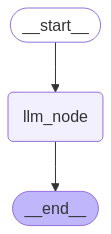

In [12]:
graph

In [15]:
input_state = {
    "messages": [HumanMessage(content="Who are you")]
}

result = graph.invoke(input_state)

In [16]:
for msg in result["messages"]:
    print(msg.content)

Who are you
I'm an AI developed by OpenAI, designed to assist with a variety of tasks and answer questions to the best of my knowledge and abilities. How can I help you today?
